In [ ]:
import numpy as np
import pandas as pd


import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import optimizers
from tensorflow.keras.layers import Dense
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import Callback

import time

In [ ]:
# copy from https://gist.github.com/stared/dfb4dfaf6d9a8501cd1cc8b8cb806d2e

from IPython.display import clear_output
from tensorflow.keras.callbacks import Callback

class PlotLosses(Callback):

  def on_train_begin(self, logs={}):

    self.i = 0
    self.x = []
    self.losses = []
    self.val_losses = []

    self.fig = plt.figure()

    self.logs = []


  def on_epoch_end(self, epoch, logs={}):

    self.logs.append(logs)
    self.x.append(self.i)
    self.losses.append(logs.get('loss'))
    self.val_losses.append(logs.get('val_loss'))
    self.i += 1

    clear_output(wait=True)
    plt.plot(self.x, self.losses, label="loss")
    plt.plot(self.x, self.val_losses, label="val_loss")
    plt.legend()
    plt.show();
    print("loss = ", self.losses[-1], ", val_loss = ", self.val_losses[-1])


In [ ]:
train=pd.read_csv('/content/sample_data/train.csv')
test=pd.read_csv('/content/sample_data/test.csv')
submission=pd.read_csv('/content/sample_data/sample_submission.csv')

In [ ]:
train1=pd.get_dummies(data=train,columns=['type'])
train1
test=pd.get_dummies(data=test,columns=['type'])
test

,index,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,type_red,type_white
0,0,9.0,0.31,0.48,6.60,0.043,11.0,73.0,0.99380,2.90,0.38,11.6,0,1
1,1,13.3,0.43,0.58,1.90,0.070,15.0,40.0,1.00040,3.06,0.49,9.0,1,0
2,2,6.5,0.28,0.27,5.20,0.040,44.0,179.0,0.99480,3.19,0.69,9.4,0,1
3,3,7.2,0.15,0.39,1.80,0.043,21.0,159.0,0.99480,3.52,0.47,10.0,0,1
4,4,6.8,0.26,0.26,2.00,0.019,23.5,72.0,0.99041,3.16,0.47,11.8,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,995,7.1,0.59,0.02,2.30,0.082,24.0,94.0,0.99744,3.55,0.53,9.7,1,0
996,996,8.7,0.15,0.30,1.60,0.046,29.0,130.0,0.99420,3.22,0.38,9.8,0,1
997,997,8.8,0.66,0.26,1.70,0.074,4.0,23.0,0.99710,3.15,0.74,9.2,1,0
998,998,7.0,0.42,0.19,2.30,0.071,18.0,36.0,0.99476,3.39,0.56,10.9,1,0


In [ ]:
from tensorflow.keras.utils import to_categorical

y_train=to_categorical(train1.loc[:,'quality'])

x_train=train1.loc[:,'fixed acidity':]
x_test=test.loc[:,'fixed acidity':]

from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler()
scaler.fit(x_train)
x_train_scaled=scaler.fit_transform(x_train)
x_test_scaled=scaler.fit_transform(x_test)
x_train_scaled.shape[1]
y_train.shape[1]


10

In [ ]:

from tensorflow.keras.regularizers import l1, l2, L1L2
model = keras.Sequential([
    keras.layers.Dense(256, activation='relu', input_dim=x_train_scaled.shape[1],kernel_regularizer=l2()),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(256, activation='relu',kernel_regularizer=l2()),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(128, activation='relu',kernel_regularizer=l2()),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(128, activation='relu',kernel_regularizer=l2()),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(y_train.shape[1], activation='softmax')
])



In [ ]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

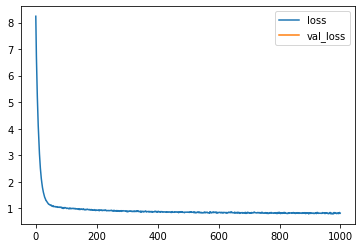

loss =  0.8180749416351318 , val_loss =  None


In [ ]:
from matplotlib import pyplot
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

model_check_point = ModelCheckpoint('best_model.h5', monitor='val_loss', mode='min', save_best_only=True)
plot_losses = PlotLosses()
early_stopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_learning_rate=0.001)

callbacks = [model_check_point, plot_losses, early_stopping, reduce_lr]

lot_losses = PlotLosses()
model.fit(x_train_scaled, y_train, batch_size=512 ,  epochs=10000, verbose=1, callbacks=[plot_losses])

In [ ]:
from tensorflow.python.keras.models import load_model
model.save('wine_model.h5')

In [ ]:
from tensorflow.keras.utils import to_categorical
from tensorflow.python.keras.models import load_model
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler()
x_test = test.loc[:,'fixed acidity':]
x_test_scaled=scaler.fit_transform(x_test)
from sklearn.preprocessing import MinMaxScaler
x_test_scaled=pd.DataFrame(x_test_scaled)
xhat=x_test_scaled.loc[:,:]
xhat

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,0.421053,0.198276,0.592593,0.269406,0.048576,0.082305,0.234043,0.376667,0.169811,0.138889,0.571429,0.0,1.0
1,0.798246,0.301724,0.716049,0.054795,0.093802,0.115226,0.117021,0.816667,0.320755,0.240741,0.107143,1.0,0.0
2,0.201754,0.172414,0.333333,0.205479,0.043551,0.353909,0.609929,0.443333,0.443396,0.425926,0.178571,0.0,1.0
3,0.263158,0.060345,0.481481,0.050228,0.048576,0.164609,0.539007,0.443333,0.754717,0.222222,0.285714,0.0,1.0
4,0.228070,0.155172,0.320988,0.059361,0.008375,0.185185,0.230496,0.150667,0.415094,0.222222,0.607143,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0.254386,0.439655,0.024691,0.073059,0.113903,0.189300,0.308511,0.619333,0.783019,0.277778,0.232143,1.0,0.0
996,0.394737,0.060345,0.370370,0.041096,0.053601,0.230453,0.436170,0.403333,0.471698,0.138889,0.250000,0.0,1.0
997,0.403509,0.500000,0.320988,0.045662,0.100503,0.024691,0.056738,0.596667,0.405660,0.472222,0.142857,1.0,0.0
998,0.245614,0.293103,0.234568,0.073059,0.095477,0.139918,0.102837,0.440667,0.632075,0.305556,0.446429,1.0,0.0


In [ ]:
from numpy import argmax
model = load_model('wine_model.h5')
yhat = model.predict(xhat)
result=[]
for i in range(1000):
  result.append(argmax(yhat[i]))
results=pd.DataFrame()
results['quality']=result
results.set_index
index=[]
for j in range(1000):
  index.append(j)
results['index']=index
results.set_index('index')
results

,quality,index
0,5,0
1,3,1
2,5,2
3,5,3
4,7,4
...,...,...
995,5,995
996,5,996
997,4,997
998,5,998


In [ ]:
results['quality'].describe()

count    1000.000000
mean        5.396000
std         0.787276
min         3.000000
25%         5.000000
50%         5.000000
75%         6.000000
max         8.000000
Name: quality, dtype: float64

In [ ]:
results.to_csv('wine.csv',index=True,header = True)
